# Определение приоритезации источников рекламы

В «Космические братья» пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.
Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

**Цель исследования:** определить какой источник рекламы эффекивнее и приоритизировать источники

**Ход исследования:**

- Изучить общую информацию о датасетах;
- Предобработка данных;
- Исследовательский анализ;
- Проверка гипотез.

**Описание данных:**

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Датасет *ad_costs.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет *user_source.csv* содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

###  Общая информция о датасетах

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
from scipy import stats as st

In [2]:
# загрузим и прочитаем датасеты
try:
    costs = pd.read_csv('~/Downloads/ad_costs.csv')
    actions = pd.read_csv('~/Downloads/game_actions.csv')
    source = pd.read_csv('~/Downloads/user_source.csv')
    
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/ad_costs.csv')
    actions = pd.read_csv('https://code.s3.yandex.net/datasets/game_actions.csv')
    source = pd.read_csv('https://code.s3.yandex.net/datasets/user_source.csv')
    

In [3]:
# создадим функцию для первичной проверки датасетов 

def first_check(dataset):

    print('Первые 5 строк таблицы: \n')
    display(dataset.head())

    print('-'*50)
    print('Информация о таблице: \n')   
    dataset.info()

    print('-'*50)
    print('Распределение данных в таблице: \n')  
    display(dataset.describe())

    print('-'*50)
    print('Название колонок: \n')  
    print(dataset.columns)
    
    print('-'*50)
    print('Количество пропущенных значений: \n')
    display(dataset.isna().sum())
    
    print('-'*50)
    print('Количество дубликатов: {}\n'.format(dataset.duplicated().sum()))

Просмотрим основную информацию о датасетах:

In [4]:
first_check(actions)

Первые 5 строк таблицы: 



,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


--------------------------------------------------
Информация о таблице: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
--------------------------------------------------
Распределение данных в таблице: 



,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


--------------------------------------------------
Название колонок: 

Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')
--------------------------------------------------
Количество пропущенных значений: 



event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

--------------------------------------------------
Количество дубликатов: 1



Удалим 1 дубликат:

In [5]:
actions=actions.drop_duplicates()

In [6]:
first_check(costs)

Первые 5 строк таблицы: 



,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


--------------------------------------------------
Информация о таблице: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
--------------------------------------------------
Распределение данных в таблице: 



,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


--------------------------------------------------
Название колонок: 

Index(['source', 'day', 'cost'], dtype='object')
--------------------------------------------------
Количество пропущенных значений: 



source    0
day       0
cost      0
dtype: int64

--------------------------------------------------
Количество дубликатов: 0



In [7]:
first_check(source)

Первые 5 строк таблицы: 



,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


--------------------------------------------------
Информация о таблице: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
--------------------------------------------------
Распределение данных в таблице: 



,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


--------------------------------------------------
Название колонок: 

Index(['user_id', 'source'], dtype='object')
--------------------------------------------------
Количество пропущенных значений: 



user_id    0
source     0
dtype: int64

--------------------------------------------------
Количество дубликатов: 0



Проверим на **неявные** дубликаты и ошибки в датасете:

*Первая проверка по зданиям:* если построено здание без типа здания или есть проект у этого события

In [8]:
def check_building(actions):
    '''
    Функция проверяет, если в столбце "event" указано "building", то проверяет, 
    есть ли в столбце "building_type" пропуски или есть ли в столбце "project_type" значение.
    '''
    # Оставляем только строки, где в столбце "event" указано "building"
    actions = actions[actions['event'] == 'building']
    
    # Проверяем, есть ли в столбце "building_type" пропуски
    null_building = actions['building_type'].isnull()
    
    # Проверяем, есть ли в столбце "project_type" значение
    not_null_project = actions['project_type'].notnull()
    
    # Возвращаем только строки, где выполнено одно из условий
    res = actions[null_building | not_null_project]
    
    return res


In [9]:
check_building(actions)

,event_datetime,event,building_type,user_id,project_type


таких ошибок нет.

*Вторую проверку сделаем по проектам:* если есть проект без типа проекта или есть здание у этого события:

In [10]:
def check_project(actions):
    '''
    Функция проверяет, если в столбце "event" указано "project", то проверяет, 
    есть ли в столбце "project_type" пропуски или есть ли в столбце "building_type" значение.
    '''
    # Оставляем только строки, где в столбце "event" указано "project"
    actions = actions[actions['event'] == 'project']
    
    # Проверяем, есть ли в столбце "project_type" пропуски
    null_project = actions['project_type'].isnull()
    
    # Проверяем, есть ли в столбце "building_type" значение
    not_null_building = actions['building_type'].notnull()
    
    # Возвращаем только строки, где выполнено одно из условий
    res = actions[null_project | not_null_building]
    
    return res

In [11]:
check_project(actions)

,event_datetime,event,building_type,user_id,project_type


таких ошибок тоже нет.

Теперь проверим по уникальным значениям в столбцах building_type и project_type.

In [12]:
print('здания:', actions['building_type'].unique())
print('проекты:', actions['project_type'].unique())

здания: ['assembly_shop' 'spaceport' nan 'research_center']
проекты: [nan 'satellite_orbital_assembly']


все названия типов зданий и проектов соответствуют ТЗ. 

In [13]:
check = actions.query('event == "finished_stage_1"')
#всего завершили уровень 5817 пользователей количество пропусков в проекте и здании должно соответствовать
check.isna().sum()

event_datetime       0
event                0
building_type     5817
user_id              0
project_type      5817
dtype: int64

С датасетом все хорошо, ошибок в пропусках не обнаружено.

**Вывод:** при первичной проверке датасетов аномалий найдено не было, данные предоставлены  в удобном формате, очищены от дубликатов . Найденные пропуски не повлияют на ход исследования.

### Предобработка данных

Подготовим наш датасет для дальнейшего анализа, для этого сначала  добавим столбец с датой в таблицу `actions` :

In [14]:
actions['date'] = pd.to_datetime(actions['event_datetime']).dt.date 

In [15]:
actions

,event_datetime,event,building_type,user_id,project_type,date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04
...,...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,2020-06-05
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,2020-06-05
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,2020-06-05
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,2020-06-05


Посмотрим, за какой период у нас есть данные:

In [16]:
print('минимальная дата:' , actions['date'].min())
print('максимальная дата:' , actions['date'].max())

минимальная дата: 2020-05-04
максимальная дата: 2020-06-05


Имеем датасет за период с 4 мая по 5 июня (месяц)

В таблице `costs` создадим новым столбец day_fact:  изменим тип даты у столбца day с object на datetime, затем сместим на 1 день, т.к. нам известно, что реклама закупалась авансом

In [17]:
costs['day_fact'] = pd.to_datetime(costs['day'])  # преобразуем столбец в объект datetime
costs['day_fact'] += pd.Timedelta(days=1)  # сдвигаем дату на 1 день вперед

Создадим новую таблицу `actions_source` путем объединения двух таблиц `actions` и `source`

In [18]:
actions_source = pd.merge(source, actions, on='user_id', how='right')

In [19]:
actions_source.head()

,user_id,source,event_datetime,event,building_type,project_type,date
0,55e92310-cb8e-4754-b622-597e124b03de,youtube_channel_reklama,2020-05-04 00:00:01,building,assembly_shop,NaN,2020-05-04
1,c07b1c10-f477-44dc-81dc-ec82254b1347,facebook_ads,2020-05-04 00:00:03,building,assembly_shop,NaN,2020-05-04
2,6edd42cc-e753-4ff6-a947-2107cd560710,instagram_new_adverts,2020-05-04 00:00:16,building,assembly_shop,NaN,2020-05-04
3,92c69003-d60a-444a-827f-8cc51bf6bf4c,facebook_ads,2020-05-04 00:00:16,building,assembly_shop,NaN,2020-05-04
4,cdc6bb92-0ccb-4490-9866-ef142f09139d,yandex_direct,2020-05-04 00:00:35,building,assembly_shop,NaN,2020-05-04


Добавим маркеры:

   * завершил уровень (исследователь) - `PVE`;
   
За исследователя будем принимать тех, кто  завершил уровень (event= finished_stage_1) и  есть проект  (event= project)     
   
   * завершил уровень (победой над игроком) - `PVP`;
   
За того, кто одержал победу над игроком, будем принимать тех, кто  завершил уровень (event= finished_stage_1) и  проект не строил 

In [20]:
# Сгруппируем пользователей по полю 'user_id'
grouped_df  = actions_source.groupby('user_id')

# создадим функцию для определения категории пользователя
def get_user_category(group):
    if 'finished_stage_1' in group['event'].values and 'project' in group['event'].values:
        return 'PVE'
    elif 'finished_stage_1' in group['event'].values:
        return 'PVP'
    else:
        return 'unfinished'

# Применим функцию к каждой группе пользователей
user_categories = grouped_df.apply(get_user_category)

# Сбросим индекс для дальнейшего объединения
user_categories = user_categories.reset_index()

# Переименуем столбец с результатами функции
user_categories = user_categories.rename(columns={0: 'user_category'})

# Объединим исходный датафрейм и датафрейм с результатами функции по идентификатору пользователя
result_df = pd.merge(actions_source, user_categories, on='user_id', how='left')


**Вывод:** Все данные подготовлены к анализу, дополнительные столбцы созданы


### Исследовательский анализ

Проведем исследование по поведению пользователей и эффектиности рекламы:

#### Как распределились пользователи к концу анализируемого периода:

In [21]:
# считаем количество уникальных пользователей для каждой категории
unique_users_by_category = result_df.groupby('user_category')['user_id'].nunique()

# вычисляем общее количество уникальных пользователей
total_unique_users = unique_users_by_category.sum()

# вычисляем долю каждой категории
fractions = (unique_users_by_category / total_unique_users*100).round()


print('Всего уникальных пользователей:' , result_df['user_id'].nunique())
print('Распределение пользователей к концу месяца в игре:')
print(fractions)

Всего уникальных пользователей: 13576
Распределение пользователей к концу месяца в игре:
user_category
PVE           14.0
PVP           29.0
unfinished    57.0
Name: user_id, dtype: float64


Всего за период исследования игру посетило более **13,5 тыс.** игроков. 
Из них:
- **57%** не прошли игру;
- **29%** прошли игру путем победы над другим игроком;
- **14%** прошли игру путем исследования и построек.

#### Есть ли связь между источником рекламы и  дохождением игрока до конца уровня?

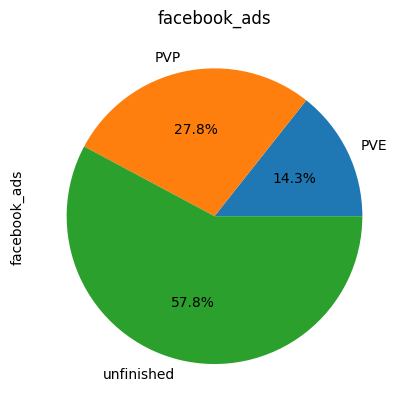

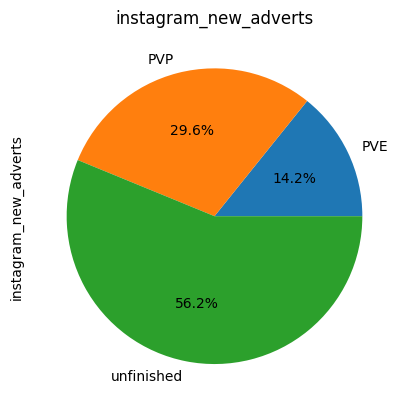

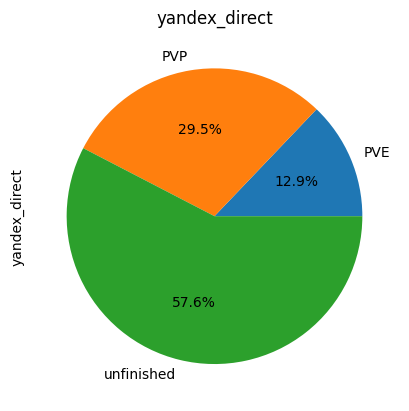

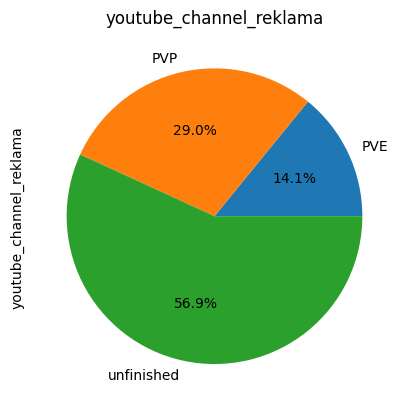

In [22]:
pt = result_df.pivot_table(index= 'user_category', values = 'user_id', columns = 'source' , aggfunc = 'nunique')

# построим круговые диаграммы для каждого источника
for col in pt.columns:
    pt[col].plot.pie(autopct='%1.1f%%')
    plt.title(col)
    plt.show()

Изучив графики, мы видим, что эти события не связаны между собой и со всех каналов игроки ведут себя в среднем одинаково. 

#### Сколько игроков пришло с каждого ресурса?

In [23]:
pt2 = (result_df.pivot_table(index= 'source', values = 'user_id', aggfunc = 'nunique')
                        .sort_values(by = 'user_id', ascending= False))

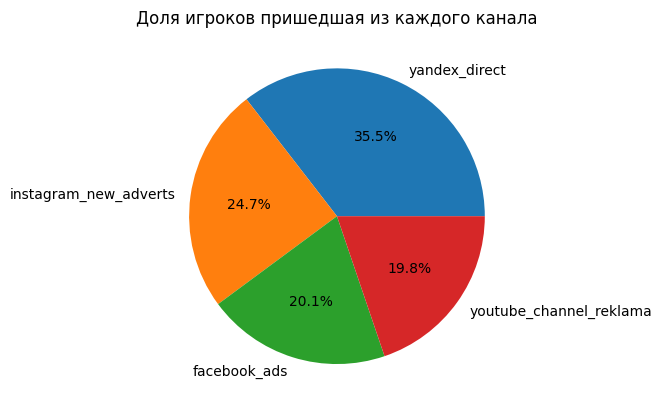

In [24]:
fig, ax = plt.subplots()

# Строим круговую диаграмму
ax.pie(pt2['user_id'], labels=pt2.index, autopct='%1.1f%%')
ax.set_title('Доля игроков пришедшая из каждого канала')
plt.show()

Как видно на графике , больше всего пользователей пришло их `yandex_direct` - **35,5%**, далее идет `instagram_new_adverts` - **24,7%** и по **20%** `facebook_ads` и `youtube_channel_reklama`.

#### Сколько пользователи сделали построек из каждого источника:

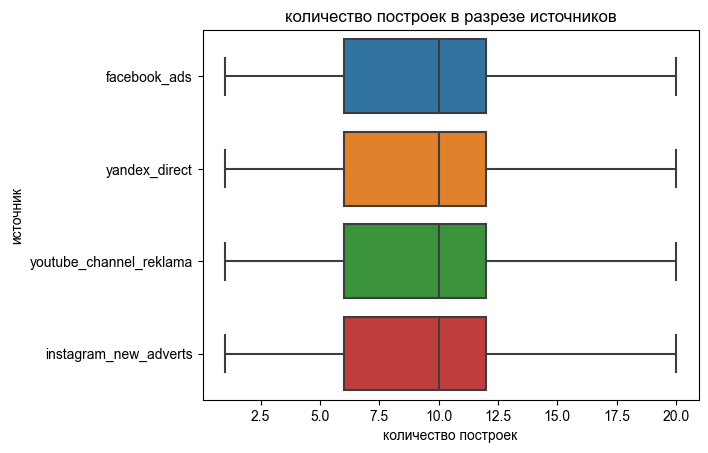

In [25]:
pt3 = (result_df.query('event == "building"')
       .pivot_table(index = ['user_id', 'source'], values='event', aggfunc = 'count').reset_index())

ax = sns.boxplot(x='event', y='source', data=pt3) 
sns.set_style('white')
plt.title('количество построек в разрезе источников')
plt.xlabel('количество построек')
plt.ylabel('источник')
plt.xticks()
plt.show()


Здесь мы видим, что количество построек не зависит от источника, из которого пришел игрок. Так, в среднем игрок строит около 10 построек за игру. 

#### Рассмотрим в разрезе источников, сколько в среднем игроки проводят время в игре:

In [26]:
# преобразуем столбец с датой в тип datetime
result_df['event_datetime'] = pd.to_datetime(result_df['event_datetime'])

# группируем данные по каждому пользователю и считаем разницу между минимальной и максимальной датами в часах
hours_diff = result_df.groupby(['user_id','source'])['event_datetime'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600).reset_index()


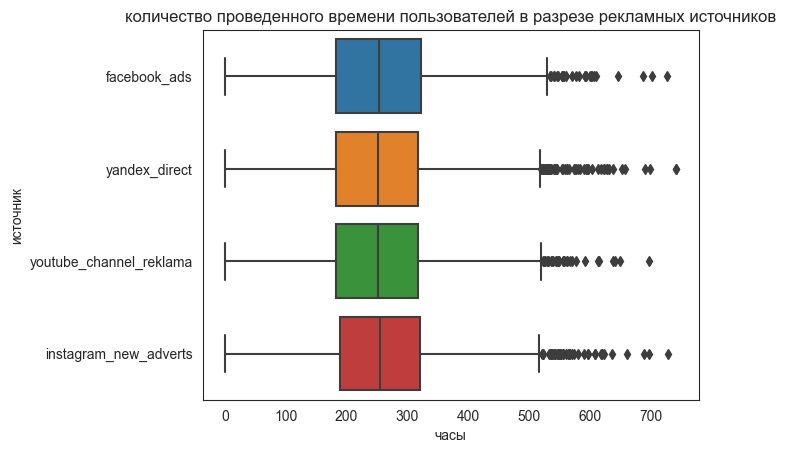

In [27]:
ax = sns.boxplot(x='event_datetime', y='source', data=hours_diff) 
sns.set_style('white')
plt.title('количество проведенного времени пользователей в разрезе рекламных источников')
plt.xlabel('часы')
plt.ylabel('источник')
plt.xticks()
plt.show()

Здесь мы видим, что в среднем игроки из разных источников проводят одинаковое количество времени в игре, однако если посмотреть на максимальное значение, то видим, что пользователи с масимальным значеним у  `facebook_ads` чуть больше, чем у остальных источников.

#### Стоимость рекламы за 1 день

Посмотрим сколько в среднем нам обходилась реклама в день в разрезе источников:

In [28]:
# добавление столбца "days", содержащего номер дня от начала периода
start_date = costs['day_fact'].min()
costs['days'] = (costs['day_fact'] - start_date).dt.days + 1

# вычисление средней стоимости по каждому источнику рекламы
mean_cost_by_source = costs.groupby('source')['cost'].mean().sort_values()

print(mean_cost_by_source)

source
youtube_channel_reklama    152.588458
facebook_ads               305.843520
instagram_new_adverts      308.777384
yandex_direct              319.015921
Name: cost, dtype: float64


Здесь мы видим, что самая дорогая реклама у нас от `yandex_direct`, а самая дешевая `youtube_channel_reklama`

#### Затраты на рекламу на 1 игрока:

Посмотрим какая стоимость 1 игрока по каждому из источников:

In [29]:
# сгруппируем стоимость по источникам рекламы
costs_source = costs.pivot_table(index = 'source', values = 'cost', aggfunc = 'sum').reset_index()

# сгруппируем и посчитаем сколько привлечено пользователей по источникам рекламы
count_users = result_df.pivot_table(index= 'source', values = 'user_id', aggfunc = 'nunique').reset_index()
count_users.columns=['source', 'count_users']

# соеденим две таблицы для дальнейших расчетов
costs_per_user = pd.merge(costs_source, count_users, on='source', how='right')

# рассчитаем среднюю стоимость за игрока
costs_per_user['costs_per_user']= (costs_per_user['cost']/costs_per_user['count_users']).round(2)
costs_per_user

,source,cost,count_users,costs_per_user
0,facebook_ads,2140.904643,2726,0.79
1,instagram_new_adverts,2161.441691,3347,0.65
2,yandex_direct,2233.111449,4817,0.46
3,youtube_channel_reklama,1068.119204,2686,0.40


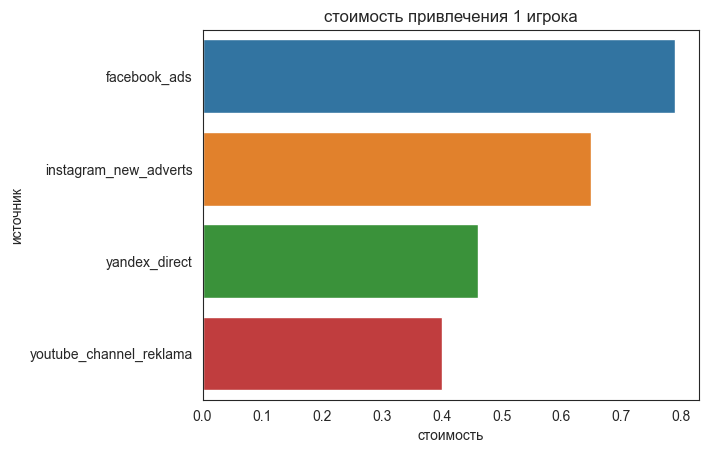

In [30]:
# построим график
ax = sns.barplot(x='costs_per_user', y='source', data=costs_per_user) 
sns.set_style('white')
plt.title('стоимость привлечения 1 игрока')
plt.xlabel('стоимость')
plt.ylabel('источник')
plt.xticks()
plt.show()

Исходя из данных, мы видим, что самая большая стоимость игрока у нас от рекламы на `facebook_ads`, самая низкая у `youtube_channel_reklama`

#### Выводы  и приоритезация источников рекламы 

У нас сложилась следующая картина по привлеченным игрокам из разных источников:

1) *Доля игроков, которая пришла из кажого источника:*

    - yandex_direct	( пришло 35% пользователей)
    - instagram_new_adverts (пришло 25% пользователей)
    - youtube_channel_reklama (пришло 20% пользователей)
    - facebook_ads (пришло 20% пользователей)
         
    
2) *Стоимость 1 дня рекламы:*

    - youtube_channel_reklama (152 y.e.)
    - facebook_ads (305 y.e.)  
    - instagram_new_adverts (308 y.e.)
    - yandex_direct	( 320 y.e.)
    

3) *Стоимость 1 привлеченного игрока:*

    - yandex_direct	( 0,46 y.e.)
    - youtube_channel_reklama (0,4 y.e.)
    - instagram_new_adverts (0,65 y.e.)
    - facebook_ads (0,79 y.e.)  

Из данных видно, что самая дорогая реклама в день у `yandex_direct`, однако стоимость 1 пользователя  составляет 0,46 рубля.
Самый дешёвый игрок к нам приходит из `youtube_channel_reklama`.
Самый дорогой игрок приходит из `facebook_ads` ( почти в 2 раза дороже, чем из `yandex_direct`) 

Исходя из данных мы предлагаем следующую **приоритизацию по источникам**:

    1) yandex_direct ( хорошая цена за 1 игрока и  привлекли  больше всего пользователей (35% от всех привлеченных))
    2) youtube_channel_reklama ( самая дешевая стоимость 1 игрока)
    3) instagram_new_adverts ( стоимость 1 игрока выше среднего и привлекла 25% пользователей от всех привлеченных)
    4) facebook_ads (самая дорогая стоимость игрока) 
        

### Проверка гипотез

- **Гипотеза №1:** время завершения уровня различается в зависимости способа прохождения:
    - *через реализацию проекта*
    - *через победу над первым игроком.*

In [31]:
#подготовим данные для проверки
hours_diff = result_df.groupby(['user_id','source', 'user_category'])['event_datetime'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600).reset_index()

Формулируем нулевую `H_0` и алтернативную гипотезу `H_a`:

```
H_0: Время (event_datetime) пользователей "PVE" = время (event_datetime) пользователей "PVP"
H_a: Время (event_datetime) пользователей "PVE" ≠ время (event_datetime) пользователей "PVP"
alpha = 0.05
```

Гипотезы будем проверять критерием Манна-Уитни, т.к. данная проверка в отличие от теста Стьюдента не требует, чтобы данные были нормально распределены или имели одинаковые дисперсии : 

In [32]:
PVP = hours_diff.query('user_category == "PVP"')
PVE = hours_diff.query('user_category == "PVE"')

results = st.mannwhitneyu(PVP['event_datetime'],PVE['event_datetime'])
alpha=.05
print(results.pvalue)


if (results.pvalue<alpha):
    
    print('Отвергаем нулевую гипотезу')
else: 
    print('Не получилось отвергнуть нулевую гипотезу')

1.1228044721644527e-106
Отвергаем нулевую гипотезу


Проверка гипотезы показала, что  между временем провождением в игре исследователей и тех, кто воюет есть.

- **Гипотеза №2:** количество построенных зданий зависит от источников рекламы
 ```
H_0: Количество строений (building) источника (source) = Количество строений (building) другого источника (source)
H_a: Количество строений (building) источника (source) ≠ Количество строений (building) другого источника (source)
Альфу будем применять с поправкой Бонферрони ( всего нам нужно сделать 6 сравнений, следовательно 0.05/6 = 0,00833)
alpha = 0,00833
```   

In [33]:
#подготовим данные для проверки

df = result_df.query('event == "building"').pivot_table(index = ['user_id', 'source'], values='event', aggfunc = 'count').reset_index()

#отфильтруем датасет по источникам

yd = df.query('source == "yandex_direct" ')
fb = df.query('source == "facebook_ads" ')
ut = df.query('source == "youtube_channel_reklama" ')
ig = df.query('source == "instagram_new_adverts" ')


In [34]:
# создадим функцию по проверке гипотез

def hyp_test(source_1,source_2):

    results = st.mannwhitneyu(source_1,source_2)
    alpha=0.00833
    print(results.pvalue)
    if (results.pvalue<alpha):    
        print('Отвергаем нулевую гипотезу')
    else: 
        print('Не получилось отвергнуть нулевую гипотезу')

In [35]:
# проведем проверку по источника

print ('1 группа: Яндекс vs Facebook')
hyp_test(yd['event'],fb['event'])
print ('----')

print ('2 группа: Яндекс vs Instagram')
hyp_test(yd['event'],ig['event'])
print ('----')

print ('3 группа: Яндекс vs Youtube')
hyp_test(yd['event'],ut['event'])
print ('----')

print ('4 группа: Facebook vs Instagram')
hyp_test(fb['event'],ig['event'])
print ('----')

print ('5 группа: Facebook vs Youtube')
hyp_test(fb['event'],ut['event'])
print ('----')

print ('6 группа: Youtube vs Instagram')
hyp_test(ut['event'],ig['event'])

1 группа: Яндекс vs Facebook
0.014383638324054673
Не получилось отвергнуть нулевую гипотезу
----
2 группа: Яндекс vs Instagram
0.1018893572665771
Не получилось отвергнуть нулевую гипотезу
----
3 группа: Яндекс vs Youtube
0.6514154789589316
Не получилось отвергнуть нулевую гипотезу
----
4 группа: Facebook vs Instagram
0.38716367306843236
Не получилось отвергнуть нулевую гипотезу
----
5 группа: Facebook vs Youtube
0.010788356347116118
Не получилось отвергнуть нулевую гипотезу
----
6 группа: Youtube vs Instagram
0.06600456483354944
Не получилось отвергнуть нулевую гипотезу


При проверке данной гипотезы мы видим, что разницы между количество построек от каждого источника нет. 

**Вывод:** При проверке первой гипотезы мы вяснили, что время прохождения игры зависит от тактики, которую выбрал игрок : исследовать или воевать. 

При проверке второй гипотезы мы убедились, что количество построек у игрока не зависит от рекламного источника.


###  Общий вывод 

Исходя из вышеизложенного можно сделать вывод, что:
1. Всего за период исследования игру посетило более 13,5 тыс. игроков.
    Из них:
        - 57% не прошли игру;
        - 29% прошли игру путем победы над другим игроком;
        - 14% прошли игру путем исследования и построек.      
2. Игроки, пришедшие из разных источников ведут себя одинаково ( доходят до конца, строят или сражаются)        
3. Больше всего пользователей пришло их `yandex_direct` - 35% от общего количества, далее из `instagram_new_adverts` пришло - 25% и по 20% `facebook_ads` и `youtube_channel_reklama`.
4. Среднее количество построек не зависит от источника рекламы, строят игроки одинаково.
5.  Стоимость 1 дня рекламы самый дорогой у `yandex_direct` (320 y.e./день), самая  дешевая у  `youtube_channel_reklama` (152 y.e./день)
6. Стоимость 1 привлеченного игрока самая низкая у `youtube_channel_reklama` - 0,4 y.e./чел., далее по стоимости идет `yandex_direct` 0,46 y.e./чел., у `instagram_new_adverts` - 0,65 y.e./чел. и  самая высокая стоимость у `facebook_ads`  0,79 y.e./чел. 
7. Исходя из данных мы предлагаем следующую **приоритизацию по источникам**:

        1) yandex_direct ( хорошая цена за 1 игрока и  привлекли  больше всего пользователей (35% от всех привлеченных))
        2) youtube_channel_reklama ( самая дешевая стоимость 1 игрока)
        3) instagram_new_adverts ( стоимость 1 игрока выше среднего и привлекла 25% пользователей от всех привлеченных)
        4) facebook_ads (самая дорогая стоимость игрока) 
8. При проверке гипотезы о том, что время завершения уровня различается в зависимости способа прохождения мы выяснили, что да , время прохождения зависит от того, какую тактику для себя выбирает игрок : исследовать или воевать.
9. При проверке гипотезы, что  количество построек у пользователей зависит от источника рекламы из которой они пришли, мы выснили, что количество построек не зависит от источника рекламы. 
 
 
 